In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import pandas as pd
from sklearn.linear_model import LinearRegression
import plotly.express as px
import sqlite3 

### Data Preprocessing

#### DATA REQUESTS REQUIREMENTS - OPTIMIZING NUMBER OF REQUESTS   - This code is comprised of a static code for historical prices + a dynamic data request code that updates everyday. 
Problem : The data can be imported as batches of 7 days for 1min interval - for a period of 30 days , I thus import 4 batches of 7 and a batch of 2. 
Then 2 minute interval can be imported in batches of 60 days. I import 1 batch of 30 days . 
Then I import (730-60) data with interval 1h 
Then the rest is imported by using 1d interval 

In [2]:
ticker ="ACN"
working_days = yf.Ticker(ticker).history(period='max', interval='1d').index.tolist()
first_day, last_day = working_days[0], working_days[-1]
num_working_days = ( last_day  -  first_day  ).days + 1
new_york_timezone = pytz.timezone('America/New_York')
today = datetime.now(new_york_timezone)

last_index = int((today-first_day).days)
ordered_list = [0,6,7,13,14,20,21,27,28,29,30,59,60,729,730]   #this is the max indeces permitted 

def insert_into_ordered_list(ordered_list, x):
    for i in range(len(ordered_list)):
        if x <= ordered_list[i]:
            ordered_list.insert(i, x)
            truncated_list = ordered_list[:i + 1]
            return truncated_list
            break
    else:
        ordered_list.append(x)
        return ordered_list

indeces_list = insert_into_ordered_list(ordered_list, last_index)

date_list = [today - timedelta(days=x) for x in range((today - first_day).days + 1)]    #!! from today to past values

pairs_list = [date_list[i].strftime("%Y-%m-%d") for i in indeces_list[::-1]]  

def associate_interval(index):
    if index <= 29:
        return "1m"
    elif 29 < index <= 60:
        return "2m"
    elif 60 < index <= 729:
        return "1h"
    else:
        return "1d"

associated_interval_list = [associate_interval(a) for a in indeces_list[::-1]]
#This is a list of same size of pairs_list . it matches the interval of each date 

#Accomodate for the worst case senario - this is rare 
if (len(pairs_list)%2 != 0) :
    pairs_list.append(pairs_list[-1]) 

pairs_interval_array = np.array([pairs_list[i:i+2] + [associated_interval_list[i]] for i in range(0, len(pairs_list), 2)])

stock =  yf.Ticker(ticker) 

base_df = pd.DataFrame()
for row in pairs_interval_array:
    start_date, end_date, interval = row
    stock = yf.Ticker(ticker)
    added_df = stock.history(start=start_date, end=end_date, interval=interval)
    base_df = pd.concat([base_df, added_df]).sort_index(ascending=False)

- ACN: No data found for this date range, symbol may be delisted


In [3]:
base_df

Open        High         Low       Close  \
2024-03-22 16:00:00-04:00  337.500000  337.500000  337.500000  337.500000   
2024-03-22 15:59:00-04:00  337.970001  338.000000  337.260010  337.489990   
2024-03-22 15:58:00-04:00  337.769989  338.049988  337.690002  337.989990   
2024-03-22 15:57:00-04:00  337.415009  337.885010  337.369995  337.779999   
2024-03-22 15:56:00-04:00  337.385010  337.529999  337.244995  337.410004   
...                               ...         ...         ...         ...   
2001-07-25 00:00:00-04:00   10.550552   10.729983   10.514666   10.729983   
2001-07-24 00:00:00-04:00   10.729982   10.744336   10.550550   10.665386   
2001-07-23 00:00:00-04:00   10.765871   10.773048   10.442895   10.765871   
2001-07-20 00:00:00-04:00   10.801757   10.801757   10.622326   10.773048   
2001-07-19 00:00:00-04:00   10.837645   10.974012   10.765872   10.887885   

                               Volume  Dividends  Stock Splits  Adj Close  
2024-03-22 16:00:00-04:00         0.0        0.0           0.0        NaN  
2024-03-22 15:59:00-04:00    125703.0        0.0           0.0        NaN  
2024-03-22 15:58:00-04:00    104341.0        0.0           0.0        NaN  
2024-03-22 15:57:00-04:00     78417.0        0.0           0.0        NaN  
2024-03-22 15:56:00-04:00     68552.0        0.0           0.0        NaN  
...                               ...        ...           ...        ...  
2001-07-25 00:00:00-04:00   4208100.0        0.0           0.0        NaN  
2001-07-24 00:00:00-04:00   3537300.0        0.0           0.0        NaN  
2001-07-23 00:00:00-04:00   7501000.0        0.0           0.0        NaN  
2001-07-20 00:00:00-04:00   9238500.0        0.0           0.0        NaN  
2001-07-19 00:00:00-04:00  34994300.0        0.0           0.0        NaN  

[17830 rows x 8 columns]

##### yfinance cannot request any 1-min interval data beyond 15:59:00 i.e. Data at 16:00:00 cannot be retreived using yf , nor below 9h30 
* Run comment code called "check for some data randomly" 

##### Strange issues w/ yfinance : 
* Only for 2024/02/22 , the price reaches 16:00:00 
* Run commented code called "find dates for which time..." 
* Also other code found on stack gives price that reads 16:00:00 (see :https://stackoverflow.com/questions/65254272/yfinance-dont-see-time-on-day-when-choosing-one-hour-intervals) 
* Hypothesis : This value might be missing because it is the last value requested?  
* Note: There are some periods where volume is 0 i.e. No stock where trade , You see that the open close are the same ,Thus:  no movement in price  - Run code names "See when traded stocks volume is 0 " 

In [4]:
'''
#title : check for some data randomly 
#debut = datetime(2024, 3, 20, 9, 0, 0)
#fine = datetime(2024, 3, 20, 17, 2, 0)
stock.history(start="2024-03-18", end="2024-03-19", interval="1m")  # use debut fine and use time bigger than 16:00:00 or even 16:00:00 , you wont reach it  
#e.g. has open 175.60 at begining of day, closed at 173.6999 , on website 173.72 for close and 175.57 for open . Something is odd
''' 
'''
#title : find dates for which time reaches 16:00:00
import datetime

timestamp_list = base_df.index.tolist()
selected_timestamps = [ts for ts in timestamp_list if ts.time() == datetime.time(16, 0)]
'''
'''
# title : see when traded stocks volume is 0
base_df[base_df["Volume"] == 0] 
'''

'\n# title : see when traded stocks volume is 0\nbase_df[base_df["Volume"] == 0] \n'

* make sql table for financial data
* create table on  ..................!!!!!!!!!!!

In [5]:
file_info = pd.read_csv("nasdaq_screener_1711028754528.csv" ) 

In [6]:
file_info

Symbol                                               Name Last Sale  \
0         A             Agilent Technologies Inc. Common Stock   $147.28   
1        AA                    Alcoa Corporation Common Stock     $31.35   
2      AACG   ATA Creativity Global American Depositary Shares     $1.27   
3      AACI            Armada Acquisition Corp. I Common Stock    $11.06   
4     AACIU                    Armada Acquisition Corp. I Unit    $11.51   
...     ...                                                ...       ...   
7090   ZVRA               Zevra Therapeutics Inc. Common Stock     $6.04   
7091   ZVSA             ZyVersa Therapeutics Inc. Common Stock    $0.821   
7092    ZWS  Zurn Elkay Water Solutions Corporation Common ...    $32.58   
7093   ZYME                        Zymeworks Inc. Common Stock    $10.75   
7094   ZYXI                            Zynex Inc. Common Stock    $13.04   

      Net Change % Change    Market Cap        Country  IPO Year   Volume  \
0          -0.11  -0.075%  4.316118e+10  United States    1999.0  1526485   
1           1.68   5.662%  5.629174e+09  United States    2016.0  7446940   
2          -0.13  -9.286%  4.016016e+07          China    2008.0    56256   
3          -0.04   -0.36%  0.000000e+00  United States    2021.0     7805   
4           0.39   3.507%  0.000000e+00  United States    2021.0     1158   
...          ...      ...           ...            ...       ...      ...   
7090        0.09   1.513%  2.187577e+08  United States       NaN   157288   
7091        0.01   1.233%  1.020747e+06  United States    2022.0   311790   
7092        0.45   1.401%  5.603634e+09  United States    2012.0   677786   
7093        0.22   2.089%  7.586084e+08  United States       NaN   736822   
7094        0.11   0.851%  4.194992e+08  United States       NaN   109649   

           Sector                                           Industry  
0     Industrials   Biotechnology: Laboratory Analytical Instruments  
1     Industrials                                           Aluminum  
2     Real Estate                            Other Consumer Services  
3         Finance                                       Blank Checks  
4         Finance                                       Blank Checks  
...           ...                                                ...  
7090  Health Care         Biotechnology: Pharmaceutical Preparations  
7091  Health Care         Biotechnology: Pharmaceutical Preparations  
7092  Industrials                    Industrial Machinery/Components  
7093  Health Care         Biotechnology: Pharmaceutical Preparations  
7094  Health Care  Biotechnology: Electromedical & Electrotherape...  

[7095 rows x 11 columns]

### Simple AR application
First I use only first 30 days ( equal intervals ) 
### MODIFY TO TAKE INTO ACCOUNT IRREGULAR TIME SERIES

#### ADAPT TO DIFF STOCKS AND DIFF ORDERS ( HYPERPARAM) 


In [21]:
#choose start date, here I will predict 5 days and use 25 days and an AR 2

#if live =False

start_date =4 #should correspond to index of index of df    challenge 
#This is the first day of testing data

#choose period ( THIS SHOULD BE ADAPTABLE TO DAYS AND HOURS/MIN)
total_period = 30

#DO IT FOR RET ALSO

prices = base_df.head(total_period)['Close'].values




In [15]:
#choose hyperparameter - autoregressive order 
q = 2

##### apply MLE / YULE WALKER / LEVINSON DURBIN / PSEUDOINVERSE / AIC / BIC / EXPANDING NON ROLLING WINDOW OLS/ MAD ON ROLLING WINDOW 

In [16]:
ind_windows = []  # Initialize an empty list to store windows
size_to_roll = len(prices)-(start_date+1)-q
dep_windows = []
rolling = False    #default = expanding       #THIS IS INPUT     CAN BE CHANGED   USER VAR 
switch_second = True
predicted_values = []


for j in range(0, start_date + 2):
    intuitive = prices[start_date+1- j:]
    intuitive = intuitive[::-1]
    

            
    
    dep_window = intuitive[(q):].reshape(-1,1)
    ind_window = np.vstack([intuitive[q - i:-i] for i in range(1, q + 1)]).T
    
    if rolling ==True : 
        if switch_second == True: 
            required_len = len(dep_window)
            print(required_len)
            switch_second = False
        dep_window = dep_window[-required_len:]
        ind_window = ind_window[-required_len:]
        #print(f"I expect 23 : dep is {len(dep_window)}, ind is {len(ind_window)}")


    model = LinearRegression().fit(ind_window,dep_window)
    
    
    prediction_ind_var= intuitive[-q:].reshape(-1,1).T  # I want to predict single point , I need to extract adequate x
    predicted_y = model.predict(prediction_ind_var)
    predicted_values.append( predicted_y)

        
        
    
    ind_windows.append(ind_window)
    dep_windows.append(dep_window)


### PLOT

In [17]:
organise_df = base_df.head(total_period)[::-1]
prices_before_pred = organise_df.head(total_period - ( start_date+1))['Close']
prices_after_pred = organise_df.iloc[total_period - ( start_date+1) : ]['Close']

#create a df for predicted values: 
dates_df = prices_after_pred.index
predicted_values_list = [float(i) for i in predicted_values][:-1]
df = pd.DataFrame({'predicted': predicted_values_list})
df_predicted_values = df.set_index(dates_df)


In [41]:
# np.sum((base_df["Volume"].values) == 0)   # 9 values for which volume is 0 
# base_df[base_df["Volume"] == 0]

In [18]:
last_real_date , last_real_price = prices_before_pred.iloc[-1:].index , prices_before_pred.iloc[-1:].values.tolist()[0]
first_pred_date, first_pred_val = df_predicted_values.head(1).index , df_predicted_values.head(1).values.tolist()[0][0]
first_real_date,  first_real_val = prices_after_pred.head(1).index , prices_after_pred.head(1).values.tolist()[0]

required_date_join_lines = last_real_date.union(first_real_date)
required_val_pred_line = [last_real_price, first_pred_val]
required_val_real_line = [last_real_price, first_real_val]

In [19]:
 # Assuming df_predicted_values is a DataFrame with datetime index
df_predicted_values.index = pd.to_datetime(df_predicted_values.index)

# Extract data for plotting
dates_before_pred = pd.to_datetime(list(prices_before_pred.keys()))
dates_after_pred = pd.to_datetime(list(prices_after_pred.keys()))

# Plotting the three lines
fig = px.line()

fig.add_scatter(x=dates_before_pred, y=list(prices_before_pred.values), mode='lines', name='Actual Past Payoff', line=dict(color="black"))
fig.add_scatter(x=dates_after_pred, y=list(prices_after_pred.values), mode='lines', line=dict(color="black"), name='Actual Future Payoff')
fig.add_scatter(x=df_predicted_values.index, y=df_predicted_values.iloc[:, 0], mode='lines', name='Predicted Payoff', line=dict(color="red"))
#ADAPT ( FILLING MISSING PARTS) 
fig.add_scatter(x=required_date_join_lines , y= required_val_pred_line , mode = 'lines', line=dict(color="red"),showlegend =False)
fig.add_scatter(x=required_date_join_lines , y= required_val_real_line , mode = 'lines', line=dict(color="black"),showlegend=False)

# Add vertical line
fig.add_shape(
    dict(
        type="line",
        x0=dates_before_pred[-1],
        y0=min(min(list(prices_before_pred.values)), min(list(prices_after_pred.values))),
        x1=dates_before_pred[-1],
        y1=max(max(list(prices_before_pred.values)), max(list(prices_after_pred.values))),
        line=dict(color="grey", dash="dash")
    )
)

# Customize the plot if needed
fig.update_layout(
    xaxis=dict(title='Period'),
    yaxis=dict(title='Payoff'),
    title='',
    legend=dict(title=''),
    plot_bgcolor='lightgrey',
)

# Show the plot
fig.show()


In [ ]:
base_df[]


##### I HAVE AS INPUT : 
* PERIOD  
* START 
* ROLLING OR EXPANDING 
* ORDER Q 
* UNTIL NOW - 1 ESTIMATION METHOD ONLY :LS 
* STILL STATIC 
##### TO DO: 
* PLOTS
* DYNAMIC ( LIVE BETTING ) 
* YULE WALKER , MLE  
* MA , MONTE CARLO , ARBITRAGE OPPORTUNITIES , MARKOV CHAINS 
* IF THERE IS TIME, CROSS VALIDATION , BEST ORDER ( ARMA) 

### Geometric Brownian Motion using Monte Carlo 

In [52]:
p_t = prices[::-1].reshape(-1,1)[1:,:]  
p_t_minus_one = prices[::-1].reshape(-1,1)[:-1,:]
r= np.log(p_t/p_t_minus_one)
sample_mean = np.mean(r)
sample_std = np.std(r)

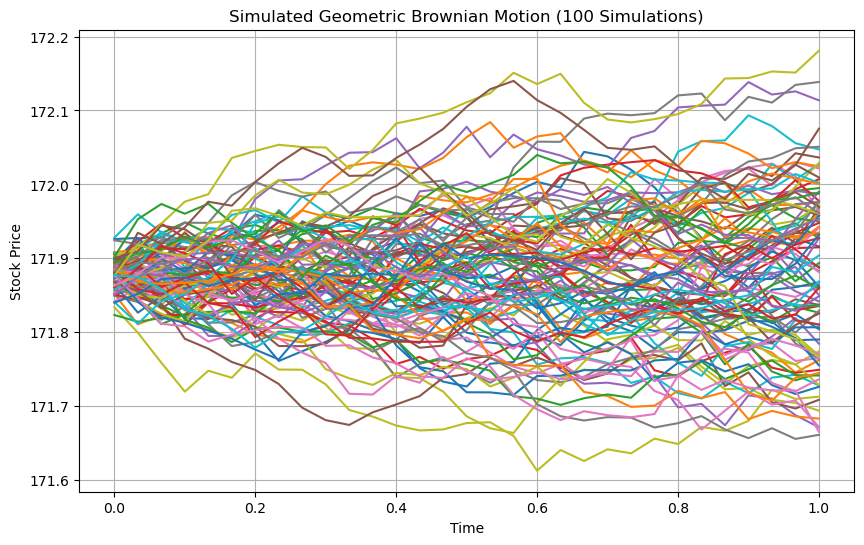

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def brownian_motion(T, N, mu, sigma, S0):
    dt = T/N
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size=N+1)
    W = np.cumsum(W) * np.sqrt(dt)  # standard Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)  # geometric Brownian motion
    return t, S

# Parameters
T = 1
N = 30  # Number of time steps
 
S0 = sorted_prices[0,0] 

# Number of simulations
num_simulations = 100

# Plot
plt.figure(figsize=(10, 6))
for _ in range(num_simulations):
    # Simulate Brownian motion
    t, S = brownian_motion(T, N, sample_mean, sample_std, S0)
    plt.plot(t, S)

plt.title('Simulated Geometric Brownian Motion (100 Simulations)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()


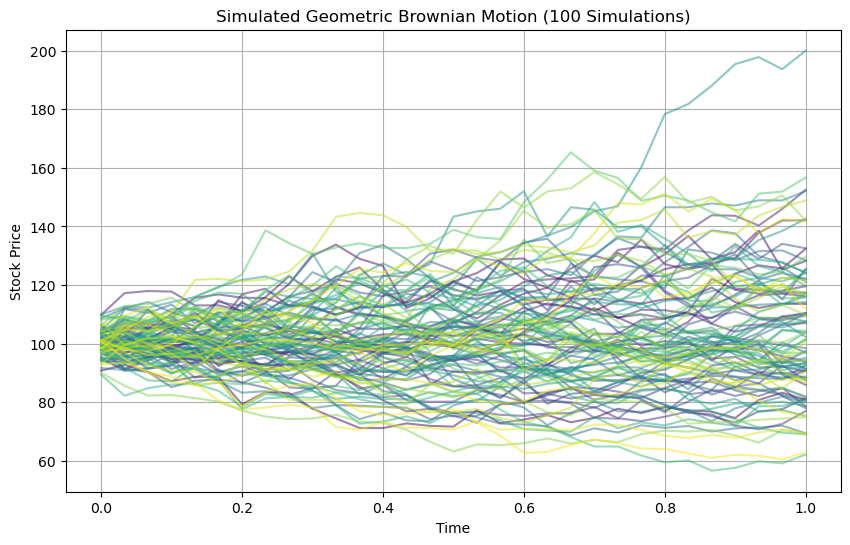

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def brownian_motion(T, N, mu, sigma, S0):
    dt = T/N
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size=N+1)
    W = np.cumsum(W) * np.sqrt(dt)  # standard Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W
    S = S0 * np.exp(X)  # geometric Brownian motion
    return t, S

# Parameters
T = 1
N = 30  # Number of time steps
sample_mean = 0.05  # Example value for mu (drift)
sample_std = 0.2  # Example value for sigma (volatility)
S0 = 100  # Example initial stock price

# Number of simulations
num_simulations = 100

# Plot
plt.figure(figsize=(10, 6))
for i in range(num_simulations):
    # Simulate Brownian motion
    t, S = brownian_motion(T, N, sample_mean, sample_std, S0)
    # Adjust transparency and colors
    plt.plot(t, S, alpha=0.5, color=plt.cm.viridis(i/num_simulations)) # Adjust color using colormap

plt.title('Simulated Geometric Brownian Motion (100 Simulations)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()
